### 1. Importing important packages

In [1]:
import numpy as np
import cv2
from scipy import linalg as la
import matplotlib.pyplot as plt

### 2. Import file (a Video called `formula1.mp4`)

In [2]:
# First a useful function to convert RGB images to grayscale
def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# Then, the main movie import function
def ImportMovie(fname):
    # Open video
    vidcap = cv2.VideoCapture(fname)
    FrameRate = vidcap.get(cv2.CAP_PROP_FPS)
    # Import first video frame
    success,image = vidcap.read()
    count = 0
    success = True
    movie = []
    # Import other frames until end of video
    while success:
        movie.append(rgb2gray(image))
        success, image = vidcap.read()
        count += 1
    # Convert to array
    movie = np.array(movie)
    # Display some summary information
    print("==========================================")
    print("           Video Import Summary           ")
    print("------------------------------------------")
    print("   Imported movie: ", fname)
    print(" Frames extracted: ", count)
    print("Frames per second: ", FrameRate)
    print("      data shape = ", movie.shape)
    print("==========================================")
    return movie, FrameRate

### 3. mat2gray

#### To take in a matrix which is an `image` and turns it into a matrix that can be plotted as a grayscale image.

In [3]:
def mat2gray(image):
    out_min = np.min(image[:])
    out_max = np.max(image[:])
    idx = np.logical_and(image > out_min, image < out_max)
    image[image <= out_min] = 0;
    image[image >= out_max] = 255;
    image[idx] = ( 255/(out_max - out_min) ) * (image[idx] - out_min)
    return image

### 4. CreateVideo

In [4]:
import os
def CreateVideo(video_name, image_folder):
    # image_folder = "."
    # video_name = "f1slow.avi"
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images = np.sort(images)
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*"mp4v"), 60, (width, height)) 
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))
    cv2.destroyAllWindows()
    video.release()

### Importing video

#### Import video by using the function `ImportMovie`, where inside the round bracket is path of the file.

In [5]:
movie, frame_rate = ImportMovie("/Users/mdmobashirulalam1/Desktop/DataDrivenAssignment/assignment-01/formula1.mp4")

           Video Import Summary           
------------------------------------------
   Imported movie:  /Users/mdmobashirulalam1/Desktop/DataDrivenAssignment/assignment-01/formula1.mp4
 Frames extracted:  758
Frames per second:  59.94005994005994
      data shape =  (758, 236, 420)


### Reshape movie to get our data Matrix

In [6]:
image_matrix_pre = np.reshape(movie, (758,99120))

image_matrix = np.transpose(image_matrix_pre) #Transpose because we want the obsevations as columns

### Applying POD for dimension reduction

In [7]:
U, S, Vh = la.svd(image_matrix, full_matrices = False) # Here S is sigma which contains eigenvalues

### Find out our coeffient for sum of coefficients and POD-modes. The matrix of C-values is our projection into lower-dimension. We know: $$X(i) = U_{r}C(i)$$ or, $$C(i) = U_{r}^\ast X(i)$$

In [8]:
pod_rank = 390
Ur = U[:,0:pod_rank]
# Out matrix C
C = Ur.conj().T @ image_matrix

### Apply DMD on lower-dimensional matrix

In [9]:
X = C[:, 0:757]   #This is actualy X_tilda in our lecture
Y = C[:, 1:758]   #This is actualy Y_tilda in our lecture

# optimal A with A*A=I where A=UV*
# M = YX*
# First we need X* to calculate M
X_conj = X.conj().T
M = Y @ X_conj

# To get the U (here U_m) and V* (here V_m), apply SVD on M
U_m, S_m, V_m = la.svd(M)

# calculate A
A = U_m @ V_m

### Use Eigenvectors expansion

In [10]:
eigenvalues, egenvectors = la.eig(A)
coeff = la.solve(egenvectors, X)

### Separate fast and slow dynamics

4


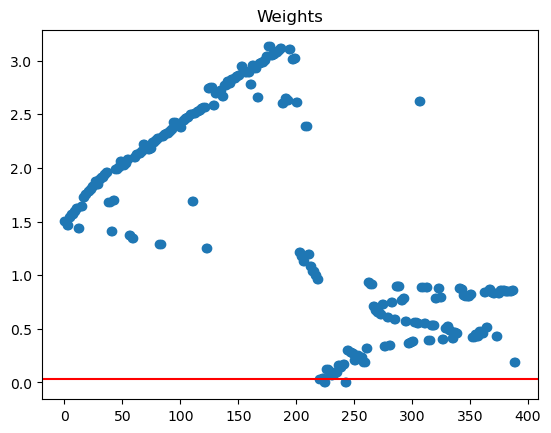

In [11]:
#ω = abs( 1j * np.log( eigenvalues / np.abs(eigenvalues) ) )  #frequency of mode j
# fast_modes = []
# slow_modes = []
# for i in range(pod_rank): 
#     if ω[i] < 0.03:
#         slow_modes.append(i)
#     else:
#         fast_modes.append(i)

# Save weights depending on eigenvectors
weights = []
# set imaginary unit
j = complex(0,1)
#compute all weights
for i in range(pod_rank):
    ev = eigenvalues[i]
    weight = abs( 1j * np.log( ev / np.abs(ev) ) ) # set the value of h=1
    weights.append(weight)
    
    
# plot weights
threshold = 0.03
plt.plot(weights, 'o')
plt.title("Weights")
plt.axhline(y=threshold, color = 'r', linestyle = '-')


fast_modes = []
slow_modes = []
for i in range(len(weights)): 
    if weights[i] < threshold:
        slow_modes.append(i)
    else:
        fast_modes.append(i)
        
print(len(slow_modes))

# save x_fast and x_slow
x_fast_list = []
x_slow_list = []

for i in range(757):
    
    # save slow dynamics
    slow_sum = 0
    for k in slow_modes:
        slow_sum += coeff[k,i] * eigenvalues[k] * egenvectors[:,k]
    x_slow_list.append(slow_sum)
    
    # save fast dynamics
    fast_sum = 0
    for m in fast_modes:
        fast_sum += coeff[m,i] * eigenvalues[m] * egenvectors[:,m]
    x_fast_list.append(fast_sum)


### Reconstruct original shape using X=U*C

In [12]:
C_slow = np.asarray(x_slow_list).T
C_fast = np.asarray(x_fast_list).T

X_slow = Ur @ C_slow
X_fast = Ur @ C_fast

#reshape
X_slow_new = np.reshape(X_slow, (236,420,757))
X_fast_new = np.reshape(X_fast, (236,420,757))

### Remove imaginary part

In [13]:
X_slow_real = np.real(X_slow_new)
X_fast_real = np.real(X_fast_new)

### Save image matrice in folder

In [15]:
# fg folder
import matplotlib.image

for i in range(757):
    name = "{:04d}".format(i)
    k= X_fast_real[:, :,i]
    image = mat2gray(k)
    matplotlib.image.imsave('/Users/mdmobashirulalam1/Desktop/DataDrivenAssignment/assignment-01/fg-img/frame_' + name + '.png', image, cmap='gray')

In [16]:
# bg folder

for i in range(757):
    name = "{:04d}".format(i)
    k= X_slow_real[:, :,i]
    image = mat2gray(k)
    matplotlib.image.imsave('/Users/mdmobashirulalam1/Desktop/DataDrivenAssignment/assignment-01/bg-img/frame_' + name + '.png', image, cmap='gray')

### convert images to video

In [17]:
CreateVideo("/Users/mdmobashirulalam1/Desktop/DataDrivenAssignment/assignment-01/fast_sableDMD.mp4", "/Users/mdmobashirulalam1/Desktop/DataDrivenAssignment/fg-img")

In [18]:
CreateVideo("/Users/mdmobashirulalam1/Desktop/DataDrivenAssignment/assignment-01/slow_sableDMD.mp4", "/Users/mdmobashirulalam1/Desktop/DataDrivenAssignment/bg-img")